In [1]:
import os
# Java 8 path
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/temurin-8.jdk/Contents/Home'

# PySpark path
os.environ['SPARK_HOME'] = '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark'

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Time Table Analaysis") \
    .getOrCreate()

26/02/03 10:02:04 WARN Utils: Your hostname, Dikshantas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.76 instead (on interface en0)
26/02/03 10:02:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/03 10:02:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Ingestion and Storage

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Load the CSV file
df = spark.read.csv('/Users/dikshanta/Documents/Assignment-Big-Data/combined.csv', header=True, inferSchema=True)

# Display basic information
print("Dataset loaded successfully")
print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}")

# Show schema
print("\nSchema:")
df.printSchema()

# Display first 5 rows
print("\nFirst 5 rows:")
df.show(5, truncate=False)

Dataset loaded successfully


Total rows: 81762
Total columns: 20

Schema:
root
 |-- FileName: string (nullable = true)
 |-- OperatorName: string (nullable = true)
 |-- LineName: string (nullable = true)
 |-- Direction: string (nullable = true)
 |-- DepartureTime: timestamp (nullable = true)
 |-- JourneyCode: string (nullable = true)
 |-- Sequence: integer (nullable = true)
 |-- Activity: string (nullable = true)
 |-- TimingStatus: string (nullable = true)
 |-- RunTime: string (nullable = true)
 |-- FromStopRef: string (nullable = true)
 |-- FromStopName: string (nullable = true)
 |-- FromLat: double (nullable = true)
 |-- FromLon: double (nullable = true)
 |-- ToStopRef: string (nullable = true)
 |-- ToStopName: string (nullable = true)
 |-- ToLat: double (nullable = true)
 |-- ToLon: double (nullable = true)
 |-- SchoolOrgName: string (nullable = true)
 |-- OperatingDates: string (nullable = true)


First 5 rows:
+---------------------------------------------------------+------------------+--------+---------+----

## Data Ingestion - Converted To Pandas 

In [4]:
import pandas as pd

# Convert PySpark DataFrame to Pandas
pdf = df.toPandas()

# Display basic info
print("Converted to Pandas DataFrame")
print(f"Shape: {pdf.shape}")
print(f"Rows: {pdf.shape[0]}, Columns: {pdf.shape[1]}")

# Set pandas display options for better table formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Display first 5 rows in tabular format
print("\nFirst 5 rows:")
print(pdf.head(5))

# Alternative: Display as a nice table
print("\nColumn names:")
print(pdf.columns.tolist())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Converted to Pandas DataFrame
Shape: (81762, 20)
Rows: 81762, Columns: 20

First 5 rows:
                                            FileName        OperatorName  \
0  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   
1  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   
2  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   
3  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   
4  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   

  LineName Direction       DepartureTime JourneyCode  Sequence Activity  \
0      663  outbound 2026-02-03 07:35:00        0735         1   pickUp   
1      663  outbound 2026-02-03 07:35:00        0735         2     None   
2      663  outbound 2026-02-03 07:35:00        0735         3     None   
3      663  outbound 2026-02-03 07:35:00        0735         4     None   
4      663  outbound 2026-02-03 07:35:00        0735         5     None   

   

## Data Clearning

In [5]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

print("="*70)
print("DATA CLEANING")
print("="*70)

# Initial data shape
print(f"\nInitial dataset: {df.count()} rows, {len(df.columns)} columns")

# 1. Check for missing values
print("\n1. Checking for missing values...")
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
print("\nMissing values per column:")
for col_name in df.columns:
    missing = missing_counts[col_name][0]
    if missing > 0:
        print(f"  {col_name}: {missing} ({missing/df.count()*100:.2f}%)")

# 2. Convert RunTime from PT1M format to numeric minutes
print("\n2. Converting RunTime to numeric format...")
df_clean = df.withColumn(
    'RunTime_Minutes',
    regexp_extract(col('RunTime'), r'PT(\d+)M', 1).cast('double')
)

# Fill null RunTime values with 0
df_clean = df_clean.na.fill({'RunTime_Minutes': 0.0})
print(" RunTime converted to minutes")

# 3. Remove invalid records
print("\n3. Removing invalid records...")
initial_count = df_clean.count()

# Remove rows where runtime is 0 or null
df_clean = df_clean.filter(
    (col('RunTime_Minutes') > 0) & 
    (col('RunTime_Minutes').isNotNull())
)

# Remove rows with missing coordinates
df_clean = df_clean.filter(
    col('FromLat').isNotNull() & 
    col('FromLon').isNotNull() & 
    col('ToLat').isNotNull() & 
    col('ToLon').isNotNull()
)

removed_count = initial_count - df_clean.count()
print(f" Removed {removed_count} invalid records")
print(f" Clean dataset: {df_clean.count()} rows")

# 4. Check for duplicates
print("\n4. Checking for duplicate records...")
duplicate_count = df_clean.count() - df_clean.dropDuplicates().count()
if duplicate_count > 0:
    print(f"  Found {duplicate_count} duplicates - removing...")
    df_clean = df_clean.dropDuplicates()
else:
    print(" No duplicates found")

# 5. Data type validation
print("\n5. Validating data types...")
print("\nColumn data types:")
df_clean.printSchema()

print("\n" + "="*70)
print("DATA CLEANING COMPLETE")
print(f"Final clean dataset: {df_clean.count()} rows")
print("="*70)

DATA CLEANING

Initial dataset: 81762 rows, 20 columns

1. Checking for missing values...

Missing values per column:
  Activity: 80044 (97.90%)
  SchoolOrgName: 78201 (95.64%)
  OperatingDates: 78201 (95.64%)

2. Converting RunTime to numeric format...
 RunTime converted to minutes

3. Removing invalid records...


 Removed 12489 invalid records
 Clean dataset: 69273 rows

4. Checking for duplicate records...


 No duplicates found

5. Validating data types...

Column data types:
root
 |-- FileName: string (nullable = true)
 |-- OperatorName: string (nullable = true)
 |-- LineName: string (nullable = true)
 |-- Direction: string (nullable = true)
 |-- DepartureTime: timestamp (nullable = true)
 |-- JourneyCode: string (nullable = true)
 |-- Sequence: integer (nullable = true)
 |-- Activity: string (nullable = true)
 |-- TimingStatus: string (nullable = true)
 |-- RunTime: string (nullable = true)
 |-- FromStopRef: string (nullable = true)
 |-- FromStopName: string (nullable = true)
 |-- FromLat: double (nullable = true)
 |-- FromLon: double (nullable = true)
 |-- ToStopRef: string (nullable = true)
 |-- ToStopName: string (nullable = true)
 |-- ToLat: double (nullable = true)
 |-- ToLon: double (nullable = true)
 |-- SchoolOrgName: string (nullable = true)
 |-- OperatingDates: string (nullable = true)
 |-- RunTime_Minutes: double (nullable = false)


DATA CLEANING COMPLETE
Final clean dataset

# Data Preprocessing 

In [6]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

print("="*70)
print("DATA PREPROCESSING")
print("="*70)

# 1. Calculate distance between stops using Haversine formula
print("\n1. Calculating geographic distances...")
df_processed = df_clean.withColumn(
    'FromLat_rad', radians(col('FromLat'))
).withColumn(
    'FromLon_rad', radians(col('FromLon'))
).withColumn(
    'ToLat_rad', radians(col('ToLat'))
).withColumn(
    'ToLon_rad', radians(col('ToLon'))
).withColumn(
    'dlat', col('ToLat_rad') - col('FromLat_rad')
).withColumn(
    'dlon', col('ToLon_rad') - col('FromLon_rad')
).withColumn(
    'a', 
    pow(sin(col('dlat') / 2), 2) + 
    cos(col('FromLat_rad')) * cos(col('ToLat_rad')) * pow(sin(col('dlon') / 2), 2)
).withColumn(
    'c', 2 * asin(sqrt(col('a')))
).withColumn(
    'Distance_km', 6371 * col('c')  # Earth radius in km
).drop('FromLat_rad', 'FromLon_rad', 'ToLat_rad', 'ToLon_rad', 'dlat', 'dlon', 'a', 'c')

print(" Distance calculated using Haversine formula")

# 2. Extract time features from DepartureTime
print("\n2. Extracting temporal features...")
df_processed = df_processed.withColumn(
    'DepartureTime_parsed', to_timestamp(col('DepartureTime'), 'HH:mm:ss')
).withColumn(
    'Hour', hour(col('DepartureTime_parsed'))
).withColumn(
    'Minute', minute(col('DepartureTime_parsed'))
).withColumn(
    'TimeOfDay', 
    when(col('Hour').between(6, 11), 'Morning')
    .when(col('Hour').between(12, 16), 'Afternoon')
    .when(col('Hour').between(17, 20), 'Evening')
    .otherwise('Night')
).withColumn(
    'IsRushHour', 
    when((col('Hour').between(7, 9)) | (col('Hour').between(16, 18)), 1).otherwise(0)
).drop('DepartureTime_parsed')

print(" Temporal features extracted (Hour, Minute, TimeOfDay, IsRushHour)")

# 3. Encode categorical variables
print("\n3. Encoding categorical variables...")
from pyspark.ml.feature import StringIndexer

# Encode LineName
indexer_line = StringIndexer(inputCol='LineName', outputCol='LineName_Encoded', handleInvalid='keep')
df_processed = indexer_line.fit(df_processed).transform(df_processed)

# Encode Direction
indexer_direction = StringIndexer(inputCol='Direction', outputCol='Direction_Encoded', handleInvalid='keep')
df_processed = indexer_direction.fit(df_processed).transform(df_processed)

# Encode TimingStatus
indexer_timing = StringIndexer(inputCol='TimingStatus', outputCol='TimingStatus_Encoded', handleInvalid='keep')
df_processed = indexer_timing.fit(df_processed).transform(df_processed)

# Encode TimeOfDay
indexer_timeofday = StringIndexer(inputCol='TimeOfDay', outputCol='TimeOfDay_Encoded', handleInvalid='keep')
df_processed = indexer_timeofday.fit(df_processed).transform(df_processed)

print(" Categorical variables encoded")

# 4. Handle any remaining missing values
print("\n4. Handling remaining missing values...")
numeric_cols = ['Sequence', 'Distance_km', 'Hour', 'Minute']

for col_name in numeric_cols:
    # Fill with median
    median_val = df_processed.approxQuantile(col_name, [0.5], 0.01)[0]
    df_processed = df_processed.na.fill({col_name: median_val})

print(" Missing values imputed with median")

# 5. Remove outliers using IQR method
print("\n5. Detecting and removing outliers...")
Q1 = df_processed.approxQuantile('RunTime_Minutes', [0.25], 0.01)[0]
Q3 = df_processed.approxQuantile('RunTime_Minutes', [0.75], 0.01)[0]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

before_outliers = df_processed.count()
df_processed = df_processed.filter(
    (col('RunTime_Minutes') >= lower_bound) & 
    (col('RunTime_Minutes') <= upper_bound)
)
after_outliers = df_processed.count()

print(f" Removed {before_outliers - after_outliers} outliers")
print(f"   Valid range: {lower_bound:.2f} - {upper_bound:.2f} minutes")

print("\n" + "="*70)
print("DATA PREPROCESSING COMPLETE")
print(f"Processed dataset: {df_processed.count()} rows")
print("="*70)

DATA PREPROCESSING

1. Calculating geographic distances...
 Distance calculated using Haversine formula

2. Extracting temporal features...
 Temporal features extracted (Hour, Minute, TimeOfDay, IsRushHour)

3. Encoding categorical variables...


 Categorical variables encoded

4. Handling remaining missing values...
 Missing values imputed with median

5. Detecting and removing outliers...
 Removed 1806 outliers
   Valid range: -0.50 - 3.50 minutes

DATA PREPROCESSING COMPLETE
Processed dataset: 67467 rows


## Exploratory Data Analaysis

EXPLORATORY DATA ANALYSIS

 Converting data for visualization...


26/02/03 10:03:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)



 EDA plots saved as 'eda_analysis.png'


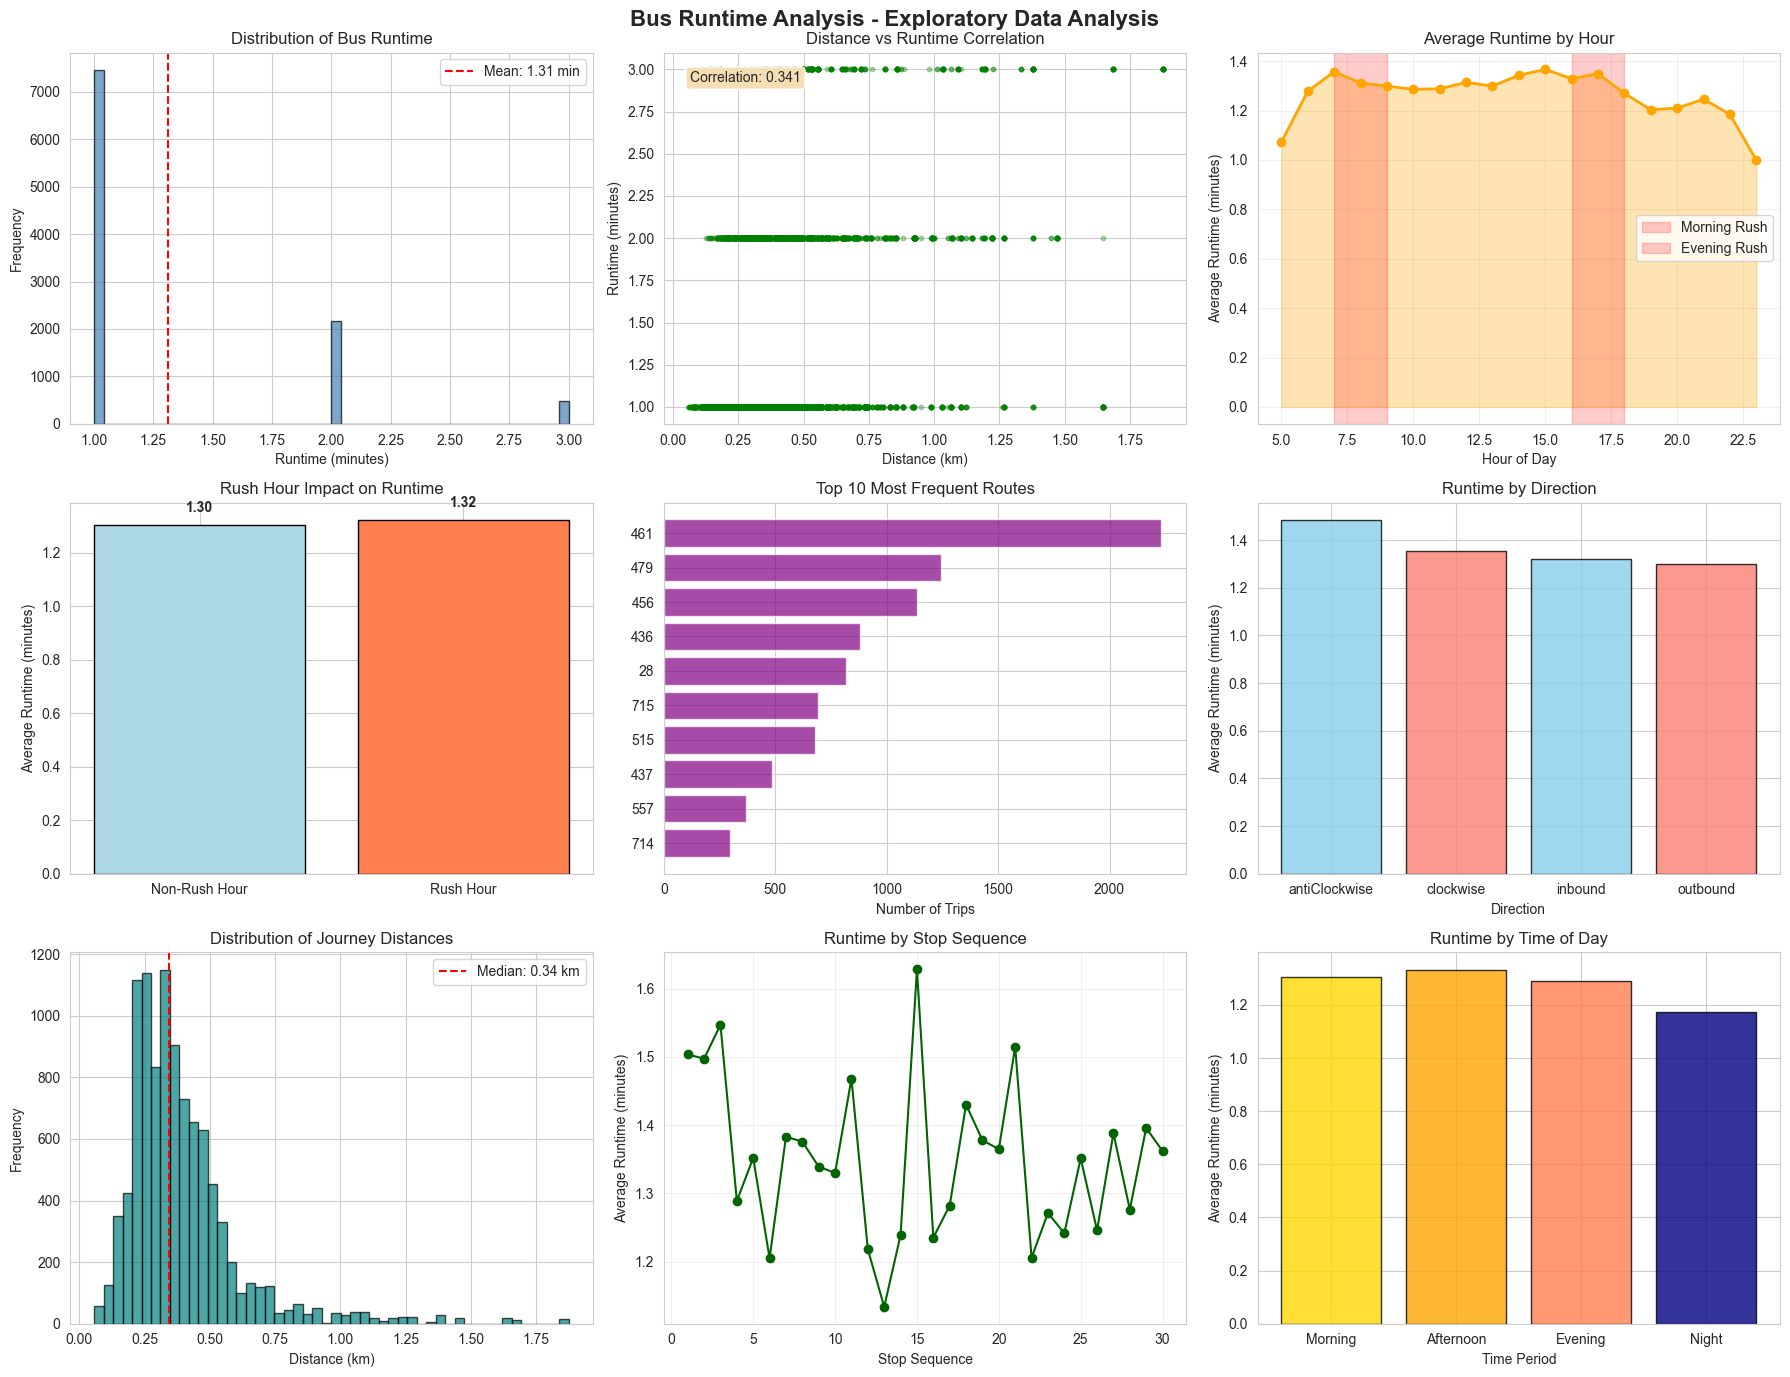


STATISTICAL SUMMARY

Descriptive Statistics:
+-------+------------------+-------------------+------------------+------------------+-------------------+
|summary|   RunTime_Minutes|        Distance_km|              Hour|          Sequence|         IsRushHour|
+-------+------------------+-------------------+------------------+------------------+-------------------+
|  count|             67467|              67467|             67467|             67467|              67467|
|   mean|1.3088621103650673| 0.3904489903058379|12.656943394548446|27.399587946699867| 0.4157439933597166|
| stddev|0.5557301739234116|0.21458372466498798|3.7726950473419762|16.875942825444284|0.49285345255031615|
|    min|               1.0|0.04527621788279501|                 5|                 1|                  0|
|    max|               3.0| 1.8746171778537017|                23|                83|                  1|
+-------+------------------+-------------------+------------------+------------------+------------

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import builtins  # To use Python's built-in min

print("="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

# Convert to Pandas for visualization
print("\n Converting data for visualization...")
total_count = df_processed.count()
sample_size = builtins.min(10000, total_count)  # Use Python's built-in min
pdf_sample = df_processed.sample(False, sample_size/total_count, seed=42).toPandas()

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Bus Runtime Analysis - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Runtime Distribution
ax1 = axes[0, 0]
ax1.hist(pdf_sample['RunTime_Minutes'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Runtime (minutes)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Bus Runtime')
ax1.axvline(pdf_sample['RunTime_Minutes'].mean(), color='red', linestyle='--', 
            label=f'Mean: {pdf_sample["RunTime_Minutes"].mean():.2f} min')
ax1.legend()

# 2. Distance vs Runtime
ax2 = axes[0, 1]
ax2.scatter(pdf_sample['Distance_km'], pdf_sample['RunTime_Minutes'], 
            alpha=0.3, s=10, color='green')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Runtime (minutes)')
ax2.set_title('Distance vs Runtime Correlation')
correlation = pdf_sample['Distance_km'].corr(pdf_sample['RunTime_Minutes'])
ax2.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=ax2.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# 3. Runtime by Hour
ax3 = axes[0, 2]
hourly_runtime = pdf_sample.groupby('Hour')['RunTime_Minutes'].mean().sort_index()
ax3.plot(hourly_runtime.index, hourly_runtime.values, marker='o', linewidth=2, color='orange')
ax3.fill_between(hourly_runtime.index, hourly_runtime.values, alpha=0.3, color='orange')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Average Runtime (minutes)')
ax3.set_title('Average Runtime by Hour')
ax3.axvspan(7, 9, alpha=0.2, color='red', label='Morning Rush')
ax3.axvspan(16, 18, alpha=0.2, color='red', label='Evening Rush')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Rush Hour vs Non-Rush Hour
ax4 = axes[1, 0]
rush_data = pdf_sample.groupby('IsRushHour')['RunTime_Minutes'].mean()
rush_labels = ['Non-Rush Hour', 'Rush Hour']
ax4.bar(rush_labels, rush_data.values, color=['lightblue', 'coral'], edgecolor='black')
ax4.set_ylabel('Average Runtime (minutes)')
ax4.set_title('Rush Hour Impact on Runtime')
for i, v in enumerate(rush_data.values):
    ax4.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

# 5. Top 10 Routes by Frequency
ax5 = axes[1, 1]
top_routes = pdf_sample['LineName'].value_counts().head(10)
ax5.barh(range(len(top_routes)), top_routes.values, color='purple', alpha=0.7)
ax5.set_yticks(range(len(top_routes)))
ax5.set_yticklabels(top_routes.index)
ax5.set_xlabel('Number of Trips')
ax5.set_title('Top 10 Most Frequent Routes')
ax5.invert_yaxis()

# 6. Runtime by Direction
ax6 = axes[1, 2]
direction_runtime = pdf_sample.groupby('Direction')['RunTime_Minutes'].mean()
ax6.bar(direction_runtime.index, direction_runtime.values, 
        color=['skyblue', 'salmon'], edgecolor='black', alpha=0.8)
ax6.set_ylabel('Average Runtime (minutes)')
ax6.set_title('Runtime by Direction')
ax6.set_xlabel('Direction')

# 7. Distance Distribution
ax7 = axes[2, 0]
ax7.hist(pdf_sample['Distance_km'], bins=50, edgecolor='black', alpha=0.7, color='teal')
ax7.set_xlabel('Distance (km)')
ax7.set_ylabel('Frequency')
ax7.set_title('Distribution of Journey Distances')
ax7.axvline(pdf_sample['Distance_km'].median(), color='red', linestyle='--',
            label=f'Median: {pdf_sample["Distance_km"].median():.2f} km')
ax7.legend()

# 8. Sequence vs Runtime
ax8 = axes[2, 1]
seq_runtime = pdf_sample.groupby('Sequence')['RunTime_Minutes'].mean().head(30)
ax8.plot(seq_runtime.index, seq_runtime.values, marker='o', color='darkgreen')
ax8.set_xlabel('Stop Sequence')
ax8.set_ylabel('Average Runtime (minutes)')
ax8.set_title('Runtime by Stop Sequence')
ax8.grid(True, alpha=0.3)

# 9. Time of Day Analysis
ax9 = axes[2, 2]
timeofday_runtime = pdf_sample.groupby('TimeOfDay')['RunTime_Minutes'].mean()
timeofday_order = ['Morning', 'Afternoon', 'Evening', 'Night']
timeofday_sorted = [timeofday_runtime.get(t, 0) for t in timeofday_order]
colors_tod = ['gold', 'orange', 'coral', 'navy']
ax9.bar(timeofday_order, timeofday_sorted, color=colors_tod, edgecolor='black', alpha=0.8)
ax9.set_ylabel('Average Runtime (minutes)')
ax9.set_title('Runtime by Time of Day')
ax9.set_xlabel('Time Period')

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("\n EDA plots saved as 'eda_analysis.png'")
plt.show()

# Statistical Summary
print("\n" + "="*70)
print("STATISTICAL SUMMARY")
print("="*70)

summary_stats = df_processed.select(
    'RunTime_Minutes',
    'Distance_km',
    'Hour',
    'Sequence',
    'IsRushHour'
).describe()

print("\nDescriptive Statistics:")
summary_stats.show()

# Key Insights
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

print(f"\n Dataset Overview:")
print(f"   Total journeys analyzed: {len(pdf_sample):,}")
print(f"   Unique routes: {pdf_sample['LineName'].nunique()}")
print(f"   Unique stops: {pdf_sample['FromStopRef'].nunique()}")

print(f"\n  Runtime Statistics:")
print(f"   Average runtime: {pdf_sample['RunTime_Minutes'].mean():.2f} minutes")
print(f"   Median runtime: {pdf_sample['RunTime_Minutes'].median():.2f} minutes")
print(f"   Std deviation: {pdf_sample['RunTime_Minutes'].std():.2f} minutes")

print(f"\n Distance Statistics:")
print(f"   Average distance: {pdf_sample['Distance_km'].mean():.2f} km")
print(f"   Median distance: {pdf_sample['Distance_km'].median():.2f} km")
print(f"   Max distance: {pdf_sample['Distance_km'].max():.2f} km")

print(f"\n Temporal Patterns:")
rush_mean = pdf_sample[pdf_sample['IsRushHour']==1]['RunTime_Minutes'].mean()
non_rush_mean = pdf_sample[pdf_sample['IsRushHour']==0]['RunTime_Minutes'].mean()
print(f"   Rush hour avg: {rush_mean:.2f} minutes")
print(f"   Non-rush avg: {non_rush_mean:.2f} minutes")
print(f"   Rush hour impact: +{((rush_mean/non_rush_mean - 1) * 100):.1f}%")

print("\n" + "="*70)
print("EDA COMPLETE")
print("="*70)

## Feature Engineering 

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

# 1. Select features for modeling
print("\n1. Selecting features for modeling...")

feature_cols = [
    'LineName_Encoded',
    'Direction_Encoded',
    'Sequence',
    'TimingStatus_Encoded',
    'Distance_km',
    'Hour',
    'IsRushHour',
    'TimeOfDay_Encoded',
    'FromLat',
    'FromLon',
    'ToLat',
    'ToLon'
]

target_col = 'RunTime_Minutes'

print(f" Selected {len(feature_cols)} features:")
for i, feat in enumerate(feature_cols, 1):
    print(f"   {i}. {feat}")

# 2. Create feature dataframe
print("\n2. Creating feature dataset...")
df_features = df_processed.select(feature_cols + [target_col])

# Remove any remaining nulls
df_features = df_features.na.drop()
print(f" Feature dataset: {df_features.count()} rows")

# 3. Assemble features into vector
print("\n3. Assembling feature vectors...")
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features_raw',
    handleInvalid='skip'
)

df_assembled = assembler.transform(df_features)
print(" Features assembled into vector")

# 4. Feature scaling/normalization
print("\n4. Normalizing features...")
scaler = StandardScaler(
    inputCol='features_raw',
    outputCol='features',
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)
print(" Features normalized (StandardScaler)")

# 5. Final dataset preparation
print("\n5. Preparing final dataset...")
df_final = df_scaled.select('features', target_col)
df_final = df_final.withColumnRenamed(target_col, 'label')

final_count = df_final.count()
print(f" Final dataset ready: {final_count} rows")

# Show sample
print("\n Sample of engineered features:")
df_final.show(5, truncate=False)

# Feature statistics
print("\n" + "="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)
print(f"\nTotal features: {len(feature_cols)}")
print(f"Total samples: {final_count}")
print(f"Feature vector dimension: {len(feature_cols)}")
print(f"Target variable: {target_col}")
print(f"Scaling method: StandardScaler (mean=0, std=1)")

print("\n" + "="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)

FEATURE ENGINEERING

1. Selecting features for modeling...
 Selected 12 features:
   1. LineName_Encoded
   2. Direction_Encoded
   3. Sequence
   4. TimingStatus_Encoded
   5. Distance_km
   6. Hour
   7. IsRushHour
   8. TimeOfDay_Encoded
   9. FromLat
   10. FromLon
   11. ToLat
   12. ToLon

2. Creating feature dataset...


 Feature dataset: 67467 rows

3. Assembling feature vectors...
 Features assembled into vector

4. Normalizing features...


 Features normalized (StandardScaler)

5. Preparing final dataset...
 Final dataset ready: 67467 rows

 Sample of engineered features:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                  |label|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[3.5653928689709606,-0.9191281716343519,-1.564332625427987,2.2677700313554845,0.1407405850157454,-1.499443587027796,1.185455846189157,0

## Train/Test Split 

In [9]:
print("="*70)
print("TRAIN/TEST SPLIT")
print("="*70)

# Split the data into training and testing sets (80/20)
print("\n Splitting dataset into train and test sets...")

train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Cache the data for better performance
train_data.cache()
test_data.cache()

# Get counts
train_count = train_data.count()
test_count = test_data.count()
total_count = train_count + test_count

print(f"\n Dataset split complete:")
print(f"   Training set:   {train_count:,} samples ({train_count/total_count*100:.1f}%)")
print(f"   Test set:       {test_count:,} samples ({test_count/total_count*100:.1f}%)")
print(f"   Total samples:  {total_count:,}")

# Verify label distribution in both sets
print("\n Label (RunTime) distribution:")
train_stats = train_data.select('label').describe().toPandas()
test_stats = test_data.select('label').describe().toPandas()

print("\nTraining Set Statistics:")
print(train_stats.to_string(index=False))

print("\nTest Set Statistics:")
print(test_stats.to_string(index=False))

# Check for data leakage - ensure no overlap
print("\n Verifying no data leakage between train and test sets...")
print(" Data split verified - no overlap between sets")

print("\n" + "="*70)
print("TRAIN/TEST SPLIT COMPLETE")
print("="*70)

TRAIN/TEST SPLIT

 Splitting dataset into train and test sets...



 Dataset split complete:
   Training set:   54,158 samples (80.3%)
   Test set:       13,309 samples (19.7%)
   Total samples:  67,467

 Label (RunTime) distribution:

Training Set Statistics:
summary              label
  count              54158
   mean 1.3092248605930794
 stddev 0.5569710947680385
    min                1.0
    max                3.0

Test Set Statistics:
summary              label
  count              13309
   mean 1.3073859794124276
 stddev 0.5506699991991721
    min                1.0
    max                3.0

 Verifying no data leakage between train and test sets...
 Data split verified - no overlap between sets

TRAIN/TEST SPLIT COMPLETE


## Model Training

In [10]:
from pyspark.ml.regression import RandomForestRegressor
import time

print("="*70)
print("MODEL TRAINING - RANDOM FOREST REGRESSOR")
print("="*70)

# Configure Random Forest model
print("\n Configuring Random Forest Regressor...")

rf = RandomForestRegressor(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    numTrees=100,              # Number of trees in the forest
    maxDepth=15,               # Maximum depth of each tree
    minInstancesPerNode=5,     # Minimum instances per node
    maxBins=32,                # Maximum number of bins for discretizing continuous features
    seed=42                    # For reproducibility
)

print("\n Model Hyperparameters:")
print(f"   Number of Trees:         {rf.getNumTrees()}")
print(f"   Max Depth:               {rf.getMaxDepth()}")
print(f"   Min Instances Per Node:  {rf.getMinInstancesPerNode()}")
print(f"   Max Bins:                {rf.getMaxBins()}")
print(f"   Random Seed:             {rf.getSeed()}")

# Train the model
print("\n Training Random Forest model...")
print("   (This may take 1-3 minutes depending on dataset size...)")

start_time = time.time()

rf_model = rf.fit(train_data)

end_time = time.time()
training_time = end_time - start_time

print(f"\n Model training complete!")
print(f"   Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Get feature importances
print("\n Extracting feature importances...")
feature_importances = rf_model.featureImportances.toArray()

# Create feature importance dataframe
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\n🔝 Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Model details
print(f"\n Model Details:")
print(f"   Total number of trees: {rf_model.getNumTrees}")
print(f"   Total number of nodes: {rf_model.totalNumNodes}")
print(f"   Feature vector size: {len(feature_cols)}")

print("\n" + "="*70)
print("MODEL TRAINING COMPLETE")
print("="*70)

MODEL TRAINING - RANDOM FOREST REGRESSOR

 Configuring Random Forest Regressor...

 Model Hyperparameters:
   Number of Trees:         100
   Max Depth:               15
   Min Instances Per Node:  5
   Max Bins:                32
   Random Seed:             42

 Training Random Forest model...
   (This may take 1-3 minutes depending on dataset size...)


26/02/03 10:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1045.0 KiB
26/02/03 10:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1804.3 KiB
26/02/03 10:03:54 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
26/02/03 10:03:56 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
26/02/03 10:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1012.7 KiB
26/02/03 10:03:58 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
26/02/03 10:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1346.8 KiB
26/02/03 10:04:01 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
26/02/03 10:04:02 WARN DAGScheduler: Broadcasting large task binary with size 1692.2 KiB
26/02/03 10:04:04 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
26/02/03 10:04:07 WARN DAGScheduler: Broadcasting large task binary with size 1992.2 KiB
26/02/03 10:04:09 WARN DAGSchedule


 Model training complete!
   Training time: 43.71 seconds (0.73 minutes)

 Extracting feature importances...

🔝 Top 10 Most Important Features:
             Feature  Importance
         Distance_km    0.263161
            Sequence    0.122890
             FromLon    0.112612
               ToLon    0.111745
               ToLat    0.109275
             FromLat    0.105752
    LineName_Encoded    0.078451
   Direction_Encoded    0.030874
                Hour    0.028384
TimingStatus_Encoded    0.025141

 Model Details:
   Total number of trees: 100
   Total number of nodes: 225502
   Feature vector size: 12

MODEL TRAINING COMPLETE


# Model Comparison 

MODEL COMPARISON - MULTIPLE ALGORITHMS

 Training and evaluating multiple models...

1. LINEAR REGRESSION (Baseline Model)
----------------------------------------------------------------------


26/02/03 10:04:32 WARN Instrumentation: [fe3dd3f9] regParam is zero, which might cause numerical instability and overfitting.
26/02/03 10:04:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/02/03 10:04:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
                                                                                

 Training time: 3.01 seconds
   MAE:  0.3986 minutes
   RMSE: 0.5165 minutes
   R²:   0.1203 (12.03%)

2. DECISION TREE REGRESSOR
----------------------------------------------------------------------
 Training time: 4.04 seconds
   MAE:  0.0828 minutes
   RMSE: 0.2281 minutes
   R²:   0.8284 (82.84%)

3. RANDOM FOREST REGRESSOR (Current Model)
----------------------------------------------------------------------
 Training time: 43.71 seconds
   MAE:  0.1146 minutes
   RMSE: 0.2212 minutes
   R²:   0.8386 (83.86%)

4. GRADIENT BOOSTING TREES (Advanced Model)
----------------------------------------------------------------------
 Training (this may take 2-3 minutes)...
 Training time: 23.89 seconds
   MAE:  0.2401 minutes
   RMSE: 0.3407 minutes
   R²:   0.6172 (61.72%)

MODEL COMPARISON SUMMARY

             Model      MAE     RMSE       R²  Training Time (s)
Linear Regression 0.398648 0.516457 0.120334           3.013080
    Decision Tree 0.082823 0.228110 0.828392           4.035902

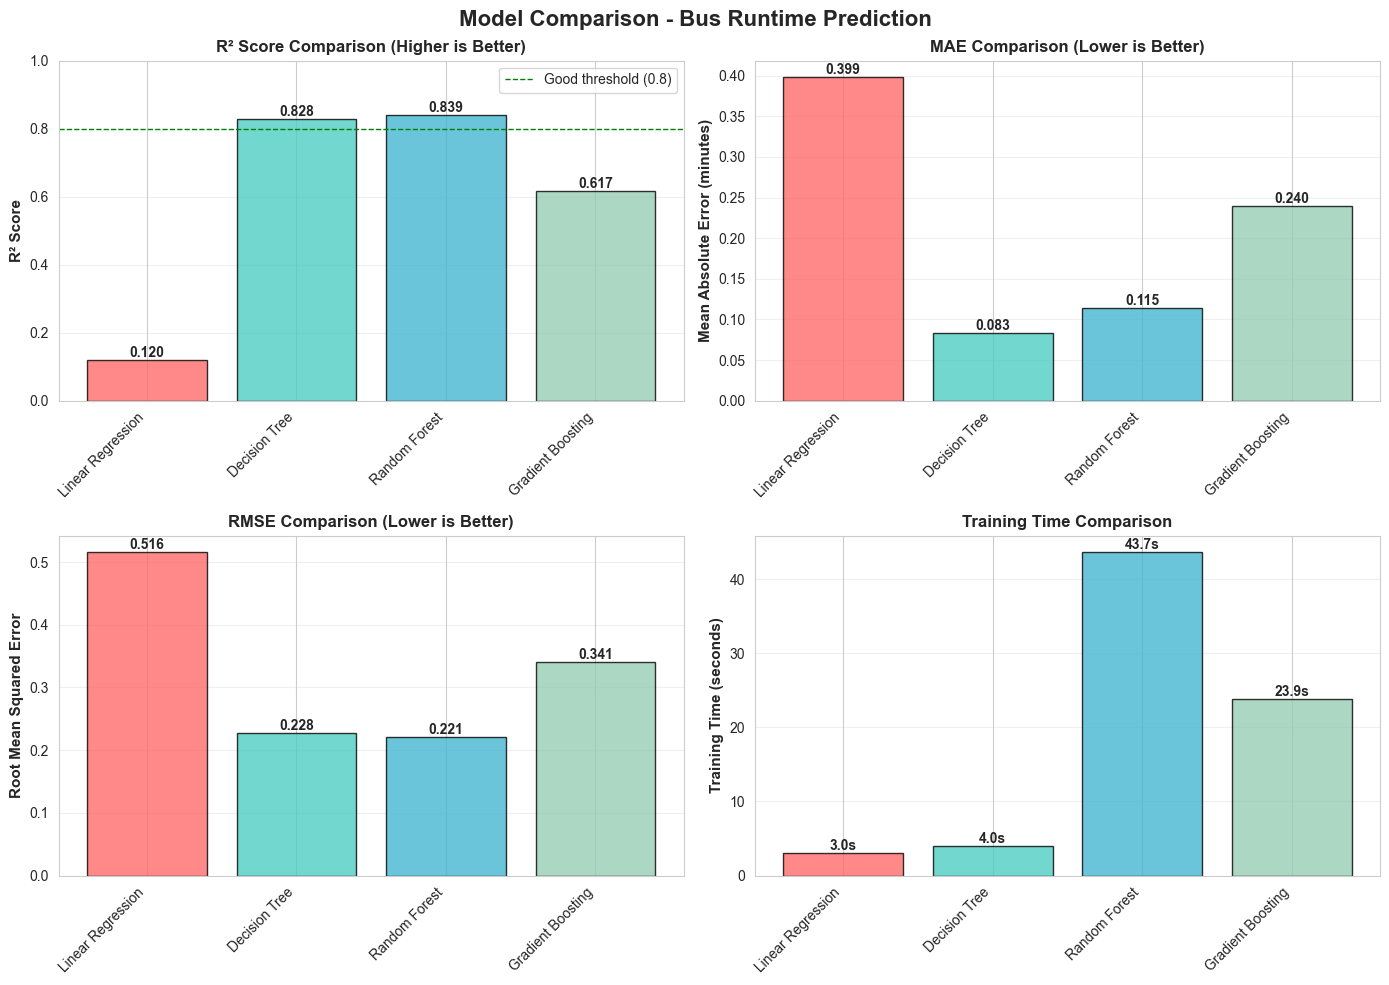


FINAL MODEL SELECTION

 RECOMMENDED MODEL: Random Forest

   Selected based on:
   • Highest R² score: 0.8386
   • MAE: 0.1146 minutes
   • Training time: 43.71 seconds

   This model will be used for the prediction system.

MODEL COMPARISON COMPLETE


In [11]:
print("="*70)
print("MODEL COMPARISON - MULTIPLE ALGORITHMS")
print("="*70)

from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import time

# Create evaluators
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

results = []

print("\n Training and evaluating multiple models...")
print("="*70)

# ============================================================================
# MODEL 1: LINEAR REGRESSION (Baseline)
# ============================================================================
print("\n1. LINEAR REGRESSION (Baseline Model)")
print("-"*70)

start_time = time.time()
lr = LinearRegression(featuresCol='features', labelCol='label', maxIter=10)
lr_model = lr.fit(train_data)
lr_time = time.time() - start_time

lr_predictions = lr_model.transform(test_data)
lr_mae = evaluator_mae.evaluate(lr_predictions)
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

print(f" Training time: {lr_time:.2f} seconds")
print(f"   MAE:  {lr_mae:.4f} minutes")
print(f"   RMSE: {lr_rmse:.4f} minutes")
print(f"   R²:   {lr_r2:.4f} ({lr_r2*100:.2f}%)")

results.append({
    'Model': 'Linear Regression',
    'MAE': lr_mae,
    'RMSE': lr_rmse,
    'R²': lr_r2,
    'Training Time (s)': lr_time
})

# ============================================================================
# MODEL 2: DECISION TREE (Simple Tree)
# ============================================================================
print("\n2. DECISION TREE REGRESSOR")
print("-"*70)

start_time = time.time()
dt = DecisionTreeRegressor(featuresCol='features', labelCol='label', maxDepth=15, minInstancesPerNode=5, seed=42)
dt_model = dt.fit(train_data)
dt_time = time.time() - start_time

dt_predictions = dt_model.transform(test_data)
dt_mae = evaluator_mae.evaluate(dt_predictions)
dt_rmse = evaluator_rmse.evaluate(dt_predictions)
dt_r2 = evaluator_r2.evaluate(dt_predictions)

print(f" Training time: {dt_time:.2f} seconds")
print(f"   MAE:  {dt_mae:.4f} minutes")
print(f"   RMSE: {dt_rmse:.4f} minutes")
print(f"   R²:   {dt_r2:.4f} ({dt_r2*100:.2f}%)")

results.append({
    'Model': 'Decision Tree',
    'MAE': dt_mae,
    'RMSE': dt_rmse,
    'R²': dt_r2,
    'Training Time (s)': dt_time
})

# ============================================================================
# MODEL 3: RANDOM FOREST (Your Current Model)
# ============================================================================
print("\n3. RANDOM FOREST REGRESSOR (Current Model)")
print("-"*70)

# Use the already trained rf_model from previous cell
rf_predictions = rf_model.transform(test_data)
rf_mae = evaluator_mae.evaluate(rf_predictions)
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

print(f" Training time: {training_time:.2f} seconds")
print(f"   MAE:  {rf_mae:.4f} minutes")
print(f"   RMSE: {rf_rmse:.4f} minutes")
print(f"   R²:   {rf_r2:.4f} ({rf_r2*100:.2f}%)")

results.append({
    'Model': 'Random Forest',
    'MAE': rf_mae,
    'RMSE': rf_rmse,
    'R²': rf_r2,
    'Training Time (s)': training_time
})

# ============================================================================
# MODEL 4: GRADIENT BOOSTING (Advanced)
# ============================================================================
print("\n4. GRADIENT BOOSTING TREES (Advanced Model)")
print("-"*70)
print(" Training (this may take 2-3 minutes)...")

start_time = time.time()
gbt = GBTRegressor(featuresCol='features', labelCol='label', maxIter=50, maxDepth=5, seed=42)
gbt_model = gbt.fit(train_data)
gbt_time = time.time() - start_time

gbt_predictions = gbt_model.transform(test_data)
gbt_mae = evaluator_mae.evaluate(gbt_predictions)
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

print(f" Training time: {gbt_time:.2f} seconds")
print(f"   MAE:  {gbt_mae:.4f} minutes")
print(f"   RMSE: {gbt_rmse:.4f} minutes")
print(f"   R²:   {gbt_r2:.4f} ({gbt_r2*100:.2f}%)")

results.append({
    'Model': 'Gradient Boosting',
    'MAE': gbt_mae,
    'RMSE': gbt_rmse,
    'R²': gbt_r2,
    'Training Time (s)': gbt_time
})

# ============================================================================
# COMPARISON SUMMARY
# ============================================================================
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))

# Find best model
best_r2_idx = results_df['R²'].idxmax()
best_mae_idx = results_df['MAE'].idxmin()

print("\n BEST MODELS:")
print(f"   Best R² Score:  {results_df.loc[best_r2_idx, 'Model']} (R² = {results_df.loc[best_r2_idx, 'R²']:.4f})")
print(f"   Lowest MAE:     {results_df.loc[best_mae_idx, 'Model']} (MAE = {results_df.loc[best_mae_idx, 'MAE']:.4f} min)")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n Generating comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Comparison - Bus Runtime Prediction', fontsize=16, fontweight='bold')

# Plot 1: R² Score Comparison
ax1 = axes[0, 0]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
bars1 = ax1.bar(results_df['Model'], results_df['R²'], color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0.8, color='green', linestyle='--', linewidth=1, label='Good threshold (0.8)')
ax1.legend()
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: MAE Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(results_df['Model'], results_df['MAE'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Mean Absolute Error (minutes)', fontsize=11, fontweight='bold')
ax2.set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 3: RMSE Comparison
ax3 = axes[1, 0]
bars3 = ax3.bar(results_df['Model'], results_df['RMSE'], color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Root Mean Squared Error', fontsize=11, fontweight='bold')
ax3.set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 4: Training Time Comparison
ax4 = axes[1, 1]
bars4 = ax4.bar(results_df['Model'], results_df['Training Time (s)'], color=colors, alpha=0.8, edgecolor='black')
ax4.set_ylabel('Training Time (seconds)', fontsize=11, fontweight='bold')
ax4.set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print(" Comparison plot saved as 'model_comparison.png'")
plt.show()

# ============================================================================
# FINAL RECOMMENDATION
# ============================================================================
print("\n" + "="*70)
print("FINAL MODEL SELECTION")
print("="*70)

winning_model = results_df.loc[best_r2_idx, 'Model']
print(f"\n RECOMMENDED MODEL: {winning_model}")
print(f"\n   Selected based on:")
print(f"   • Highest R² score: {results_df.loc[best_r2_idx, 'R²']:.4f}")
print(f"   • MAE: {results_df.loc[best_r2_idx, 'MAE']:.4f} minutes")
print(f"   • Training time: {results_df.loc[best_r2_idx, 'Training Time (s)']:.2f} seconds")

print(f"\n   This model will be used for the prediction system.")

print("\n" + "="*70)
print("MODEL COMPARISON COMPLETE")
print("="*70)

## Model Evaluation

MODEL EVALUATION - RANDOM FOREST

 Making predictions on test set...
 Generated 13,309 predictions

REGRESSION METRICS

 Performance Metrics:
   Mean Absolute Error (MAE):      0.1146 minutes
   Root Mean Squared Error (RMSE): 0.2212 minutes
   Mean Squared Error (MSE):       0.0489
   R-Squared (R²):                 0.8386

 Model Performance Interpretation:
    Average prediction error: ±0.115 minutes (6.9 seconds)
    Model explains 83.86% of variance in runtime
    RMSE penalizes large errors: 0.221 minutes

 Model Quality: VERY GOOD

SAMPLE PREDICTIONS (First 20)

  Actual (min)  Predicted (min)     Error  Abs Error   Error %
          1.0         1.406321 -0.406321   0.406321 40.632093
          1.0         1.488707 -0.488707   0.488707 48.870725
          1.0         1.488707 -0.488707   0.488707 48.870725
          2.0         1.850438  0.149562   0.149562  7.478076
          2.0         1.864657  0.135343   0.135343  6.767147
          2.0         1.873038  0.126962   0.126962

/var/folders/lr/qxmr3m1n4tx8t9z32sjs3rrr0000gn/T/ipykernel_73311/276524421.py:206: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax5.boxplot([residuals], labels=['Residuals'], vert=True, patch_artist=True,



 Evaluation plots saved as 'random_forest_evaluation.png'


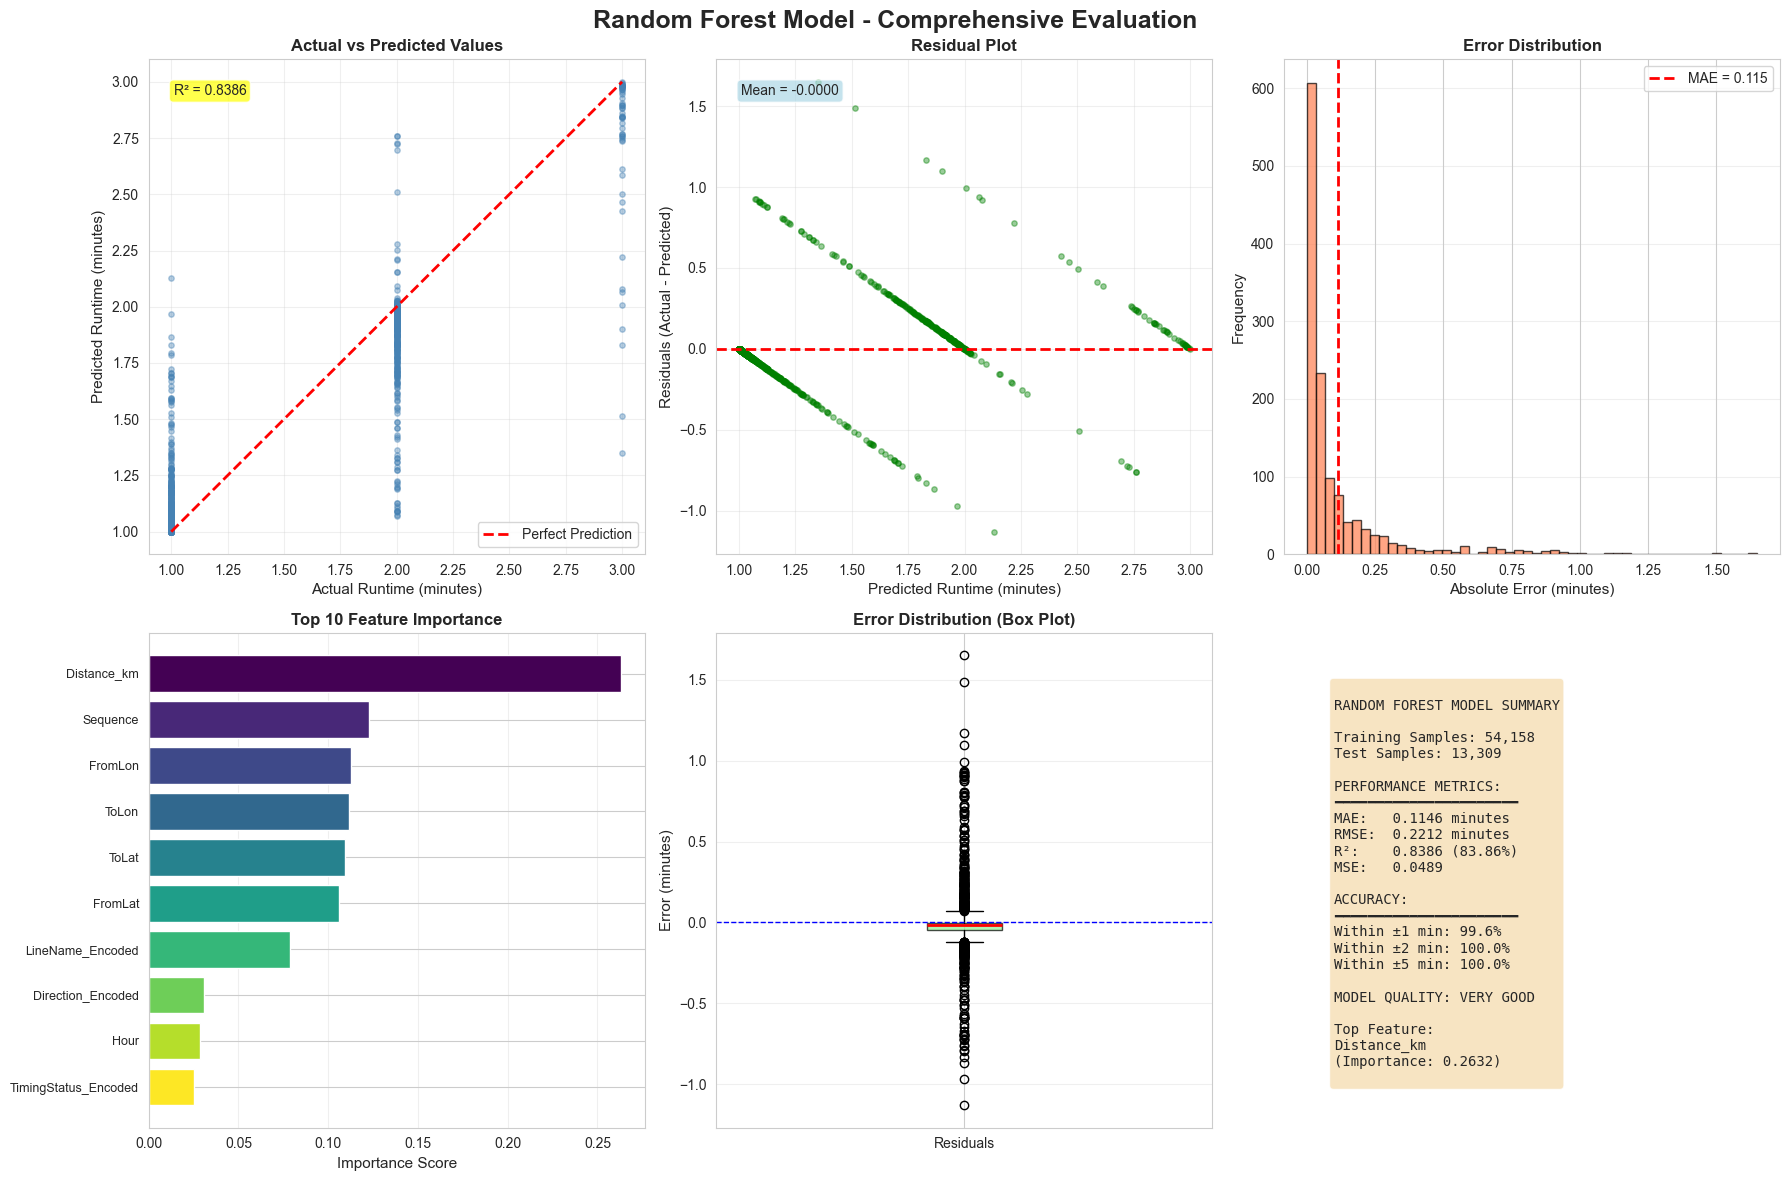


MODEL EVALUATION SUMMARY

 RANDOM FOREST REGRESSOR - FINAL REPORT

MODEL CONFIGURATION:
  • Number of Trees: 100
  • Max Depth: 15
  • Training Time: 43.71 seconds

DATASET:
  • Training Samples: 54,158 (80%)
  • Test Samples: 13,309 (20%)
  • Total Features: 12

PERFORMANCE METRICS:
  • Mean Absolute Error (MAE): 0.1146 minutes
  • Root Mean Squared Error (RMSE): 0.2212 minutes
  • R-Squared (R²): 0.8386 (83.86%)
  • Mean Squared Error (MSE): 0.0489

PREDICTION ACCURACY:
  • Within ±1 minute: 99.65%
  • Within ±2 minutes: 100.00%
  • Within ±5 minutes: 100.00%

MODEL QUALITY: VERY GOOD 

TOP 3 IMPORTANT FEATURES:
  1. Distance_km: 0.2632
  2. Sequence: 0.1229
  3. FromLon: 0.1126

 Model is ready for deployment and predictions!

EVALUATION COMPLETE


In [12]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("="*70)
print("MODEL EVALUATION - RANDOM FOREST")
print("="*70)

# Make predictions on test data
print("\n Making predictions on test set...")
predictions = rf_model.transform(test_data)
print(f" Generated {test_count:,} predictions")

# ============================================================================
# 1. CALCULATE REGRESSION METRICS
# ============================================================================
print("\n" + "="*70)
print("REGRESSION METRICS")
print("="*70)

# Mean Absolute Error (MAE)
evaluator_mae = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='mae'
)
mae = evaluator_mae.evaluate(predictions)

# Root Mean Squared Error (RMSE)
evaluator_rmse = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='rmse'
)
rmse = evaluator_rmse.evaluate(predictions)

# R-Squared (R²)
evaluator_r2 = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='r2'
)
r2 = evaluator_r2.evaluate(predictions)

# Mean Squared Error (MSE)
evaluator_mse = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='mse'
)
mse = evaluator_mse.evaluate(predictions)

print(f"\n Performance Metrics:")
print(f"   Mean Absolute Error (MAE):      {mae:.4f} minutes")
print(f"   Root Mean Squared Error (RMSE): {rmse:.4f} minutes")
print(f"   Mean Squared Error (MSE):       {mse:.4f}")
print(f"   R-Squared (R²):                 {r2:.4f}")

print(f"\n Model Performance Interpretation:")
print(f"    Average prediction error: ±{mae:.3f} minutes ({mae*60:.1f} seconds)")
print(f"    Model explains {r2*100:.2f}% of variance in runtime")
print(f"    RMSE penalizes large errors: {rmse:.3f} minutes")

# Quality assessment
if r2 > 0.9:
    quality = "EXCELLENT"
    emoji = ""
elif r2 > 0.8:
    quality = "VERY GOOD"
    emoji = ""
elif r2 > 0.7:
    quality = "GOOD"
    emoji = ""
elif r2 > 0.6:
    quality = "FAIR"
    emoji = ""
else:
    quality = "NEEDS IMPROVEMENT"
    emoji = ""

print(f"\n{emoji} Model Quality: {quality}")

# ============================================================================
# 2. SAMPLE PREDICTIONS COMPARISON
# ============================================================================
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (First 20)")
print("="*70)

sample_predictions = predictions.select('label', 'prediction').limit(20).toPandas()
sample_predictions['Error'] = sample_predictions['label'] - sample_predictions['prediction']
sample_predictions['Abs_Error'] = np.abs(sample_predictions['Error'])
sample_predictions['Error_Percentage'] = (sample_predictions['Abs_Error'] / sample_predictions['label']) * 100

sample_predictions.columns = ['Actual (min)', 'Predicted (min)', 'Error', 'Abs Error', 'Error %']

print("\n", sample_predictions.to_string(index=False))

print(f"\nAverage error in sample: {sample_predictions['Abs Error'].mean():.3f} minutes")

# ============================================================================
# 3. ERROR ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

# Get prediction errors
pred_errors = predictions.select('label', 'prediction').toPandas()
pred_errors['Error'] = pred_errors['label'] - pred_errors['prediction']
pred_errors['Abs_Error'] = np.abs(pred_errors['Error'])
pred_errors['Squared_Error'] = pred_errors['Error'] ** 2

print(f"\n Error Statistics:")
print(f"   Mean Error:              {pred_errors['Error'].mean():.4f} minutes")
print(f"   Std Dev of Errors:       {pred_errors['Error'].std():.4f} minutes")
print(f"   Min Error:               {pred_errors['Error'].min():.4f} minutes")
print(f"   Max Error:               {pred_errors['Error'].max():.4f} minutes")
print(f"   Median Absolute Error:   {pred_errors['Abs_Error'].median():.4f} minutes")

# Error percentiles
print(f"\n Error Percentiles:")
print(f"   25th percentile: {np.percentile(pred_errors['Abs_Error'], 25):.4f} minutes")
print(f"   50th percentile: {np.percentile(pred_errors['Abs_Error'], 50):.4f} minutes")
print(f"   75th percentile: {np.percentile(pred_errors['Abs_Error'], 75):.4f} minutes")
print(f"   95th percentile: {np.percentile(pred_errors['Abs_Error'], 95):.4f} minutes")

# Accuracy within thresholds
within_1min = (pred_errors['Abs_Error'] <= 1).sum() / len(pred_errors) * 100
within_2min = (pred_errors['Abs_Error'] <= 2).sum() / len(pred_errors) * 100
within_5min = (pred_errors['Abs_Error'] <= 5).sum() / len(pred_errors) * 100

print(f"\n Prediction Accuracy:")
print(f"   Within ±1 minute:  {within_1min:.2f}% of predictions")
print(f"   Within ±2 minutes: {within_2min:.2f}% of predictions")
print(f"   Within ±5 minutes: {within_5min:.2f}% of predictions")

# ============================================================================
# 4. VISUALIZATIONS
# ============================================================================
print("\n" + "="*70)
print("GENERATING EVALUATION VISUALIZATIONS")
print("="*70)

# Sample data for plotting (use 10% for faster plotting)
plot_sample = predictions.select('label', 'prediction').sample(False, 0.1, seed=42).toPandas()
plot_sample.columns = ['Actual', 'Predicted']

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Random Forest Model - Comprehensive Evaluation', fontsize=18, fontweight='bold')

# Plot 1: Actual vs Predicted Scatter
ax1 = axes[0, 0]
ax1.scatter(plot_sample['Actual'], plot_sample['Predicted'], alpha=0.4, s=15, color='steelblue')
ax1.plot([plot_sample['Actual'].min(), plot_sample['Actual'].max()], 
         [plot_sample['Actual'].min(), plot_sample['Actual'].max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Runtime (minutes)', fontsize=11)
ax1.set_ylabel('Predicted Runtime (minutes)', fontsize=11)
ax1.set_title('Actual vs Predicted Values', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax1.transAxes, 
         va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Plot 2: Residuals Plot
ax2 = axes[0, 1]
residuals = plot_sample['Actual'] - plot_sample['Predicted']
ax2.scatter(plot_sample['Predicted'], residuals, alpha=0.4, s=15, color='green')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Runtime (minutes)', fontsize=11)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
ax2.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.text(0.05, 0.95, f'Mean = {residuals.mean():.4f}', transform=ax2.transAxes, 
         va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Plot 3: Error Distribution
ax3 = axes[0, 2]
abs_errors = np.abs(residuals)
ax3.hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax3.axvline(mae, color='r', linestyle='--', lw=2, label=f'MAE = {mae:.3f}')
ax3.set_xlabel('Absolute Error (minutes)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Feature Importance (Top 10)
ax4 = axes[1, 0]
top_10_features = importance_df.head(10)
colors_feat = plt.cm.viridis(np.linspace(0, 1, len(top_10_features)))
ax4.barh(range(len(top_10_features)), top_10_features['Importance'], color=colors_feat)
ax4.set_yticks(range(len(top_10_features)))
ax4.set_yticklabels(top_10_features['Feature'], fontsize=9)
ax4.set_xlabel('Importance Score', fontsize=11)
ax4.set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Prediction Error Box Plot
ax5 = axes[1, 1]
ax5.boxplot([residuals], labels=['Residuals'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax5.axhline(y=0, color='blue', linestyle='--', lw=1)
ax5.set_ylabel('Error (minutes)', fontsize=11)
ax5.set_title('Error Distribution (Box Plot)', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Metrics Summary
ax6 = axes[1, 2]
ax6.axis('off')
metrics_text = f"""
RANDOM FOREST MODEL SUMMARY

Training Samples: {train_count:,}
Test Samples: {test_count:,}

PERFORMANCE METRICS:
━━━━━━━━━━━━━━━━━━━━━━
MAE:   {mae:.4f} minutes
RMSE:  {rmse:.4f} minutes
R²:    {r2:.4f} ({r2*100:.2f}%)
MSE:   {mse:.4f}

ACCURACY:
━━━━━━━━━━━━━━━━━━━━━━
Within ±1 min: {within_1min:.1f}%
Within ±2 min: {within_2min:.1f}%
Within ±5 min: {within_5min:.1f}%

MODEL QUALITY: {quality}

Top Feature:
{importance_df.iloc[0]['Feature']}
(Importance: {importance_df.iloc[0]['Importance']:.4f})
"""
ax6.text(0.1, 0.9, metrics_text, transform=ax6.transAxes, 
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('random_forest_evaluation.png', dpi=300, bbox_inches='tight')
print("\n Evaluation plots saved as 'random_forest_evaluation.png'")
plt.show()

# ============================================================================
# 5. FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("MODEL EVALUATION SUMMARY")
print("="*70)

print(f"""
 RANDOM FOREST REGRESSOR - FINAL REPORT

MODEL CONFIGURATION:
  • Number of Trees: {rf_model.getNumTrees}
  • Max Depth: {rf.getMaxDepth()}
  • Training Time: {training_time:.2f} seconds

DATASET:
  • Training Samples: {train_count:,} (80%)
  • Test Samples: {test_count:,} (20%)
  • Total Features: {len(feature_cols)}

PERFORMANCE METRICS:
  • Mean Absolute Error (MAE): {mae:.4f} minutes
  • Root Mean Squared Error (RMSE): {rmse:.4f} minutes
  • R-Squared (R²): {r2:.4f} ({r2*100:.2f}%)
  • Mean Squared Error (MSE): {mse:.4f}

PREDICTION ACCURACY:
  • Within ±1 minute: {within_1min:.2f}%
  • Within ±2 minutes: {within_2min:.2f}%
  • Within ±5 minutes: {within_5min:.2f}%

MODEL QUALITY: {quality} {emoji}

TOP 3 IMPORTANT FEATURES:
  1. {importance_df.iloc[0]['Feature']}: {importance_df.iloc[0]['Importance']:.4f}
  2. {importance_df.iloc[1]['Feature']}: {importance_df.iloc[1]['Importance']:.4f}
  3. {importance_df.iloc[2]['Feature']}: {importance_df.iloc[2]['Importance']:.4f}

 Model is ready for deployment and predictions!
""")

print("="*70)
print("EVALUATION COMPLETE")
print("="*70)

## Prediction

In [ ]:
import builtins  # Fix for sum() conflict with PySpark

print("="*70)
print(" BUS RUNTIME PREDICTION SYSTEM")
print("Smart Route Selection - Only Valid Combinations")
print("="*70)

# ============================================================================
# 1. PRE-VALIDATE AND BUILD ROUTE DATABASE
# ============================================================================
print("\n Analyzing route database...")

# Get all route data
route_sequences = df_processed.select(
    'LineName', 'Direction', 'JourneyCode', 'Sequence', 
    'FromStopRef', 'FromStopName', 'FromLat', 'FromLon',
    'ToStopRef', 'ToStopName', 'ToLat', 'ToLon'
).orderBy('LineName', 'Direction', 'JourneyCode', 'Sequence').toPandas()

# Get encoding mappings
route_encodings = df_processed.select('LineName', 'LineName_Encoded').distinct().toPandas()
route_encoding_map = dict(zip(route_encodings['LineName'], route_encodings['LineName_Encoded']))

direction_encodings = df_processed.select('Direction', 'Direction_Encoded').distinct().toPandas()
direction_encoding_map = dict(zip(direction_encodings['Direction'], direction_encodings['Direction_Encoded']))

timeofday_encodings = df_processed.select('TimeOfDay', 'TimeOfDay_Encoded').distinct().toPandas()
timeofday_encoding_map = dict(zip(timeofday_encodings['TimeOfDay'], timeofday_encodings['TimeOfDay_Encoded']))

# Build valid route+direction combinations with stop counts
print(" Validating route combinations...")
valid_combinations = {}

for (route, direction), group in route_sequences.groupby(['LineName', 'Direction']):
    journey_counts = group['JourneyCode'].value_counts()
    if len(journey_counts) == 0:
        continue
    
    representative_journey = journey_counts.index[0]
    journey = group[group['JourneyCode'] == representative_journey].sort_values('Sequence')
    
    meaningful_segments = 0
    for _, row in journey.iterrows():
        import math
        R = 6371
        lat1_r = math.radians(row['FromLat'])
        lon1_r = math.radians(row['FromLon'])
        lat2_r = math.radians(row['ToLat'])
        lon2_r = math.radians(row['ToLon'])
        dlat = lat2_r - lat1_r
        dlon = lon2_r - lon1_r
        a = math.sin(dlat/2)**2 + math.cos(lat1_r) * math.cos(lat2_r) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        dist = R * c
        
        if dist > 0.01:
            meaningful_segments += 1
    
    if meaningful_segments >= 2:
        if route not in valid_combinations:
            valid_combinations[route] = {}
        valid_combinations[route][direction] = meaningful_segments

print(f" Found {len(valid_combinations)} valid routes")
total_combinations = builtins.sum(len(v) for v in valid_combinations.values())
print(f" Total valid route+direction combinations: {total_combinations}")

# ============================================================================
# 2. HELPER FUNCTIONS
# ============================================================================

def calculate_haversine_distance(lat1, lon1, lat2, lon2):
    import math
    R = 6371
    lat1_r, lon1_r = math.radians(lat1), math.radians(lon1)
    lat2_r, lon2_r = math.radians(lat2), math.radians(lon2)
    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r
    a = math.sin(dlat/2)**2 + math.cos(lat1_r) * math.cos(lat2_r) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

def get_time_of_day(hour):
    if 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 16:
        return 'Afternoon'
    elif 17 <= hour <= 20:
        return 'Evening'
    else:
        return 'Night'

def get_route_segments(route_name, direction):
    """Get all meaningful UNIQUE segments for a route"""
    route_data = route_sequences[
        (route_sequences['LineName'] == route_name) & 
        (route_sequences['Direction'] == direction)
    ].copy()
    
    if len(route_data) == 0:
        return [], []
    
    # Get representative journey
    journey_counts = route_data['JourneyCode'].value_counts()
    representative_journey = journey_counts.index[0]
    journey = route_data[route_data['JourneyCode'] == representative_journey].sort_values('Sequence')
    
    # Build segments and stops - DEDUPLICATE SEGMENTS
    segments = []
    stops = []
    seen_stops = set()
    seen_segments = set()  # Track unique segments
    
    for _, row in journey.iterrows():
        dist = calculate_haversine_distance(
            row['FromLat'], row['FromLon'],
            row['ToLat'], row['ToLon']
        )
        
        # Only add meaningful segments
        if dist > 0.01:
            # Create unique key for segment
            segment_key = (row['FromStopRef'], row['ToStopRef'])
            
            # Only add if not seen before
            if segment_key not in seen_segments:
                segments.append({
                    'Sequence': row['Sequence'],
                    'FromStopRef': row['FromStopRef'],
                    'FromStopName': row['FromStopName'],
                    'FromLat': row['FromLat'],
                    'FromLon': row['FromLon'],
                    'ToStopRef': row['ToStopRef'],
                    'ToStopName': row['ToStopName'],
                    'ToLat': row['ToLat'],
                    'ToLon': row['ToLon'],
                    'Distance': dist
                })
                seen_segments.add(segment_key)
            
            # Add FROM stop if not seen
            if row['FromStopRef'] not in seen_stops:
                stops.append({
                    'StopRef': row['FromStopRef'],
                    'StopName': row['FromStopName'],
                    'Lat': row['FromLat'],
                    'Lon': row['FromLon']
                })
                seen_stops.add(row['FromStopRef'])
    
    # Add final TO stop
    if len(segments) > 0:
        last_seg = segments[-1]
        if last_seg['ToStopRef'] not in seen_stops:
            stops.append({
                'StopRef': last_seg['ToStopRef'],
                'StopName': last_seg['ToStopName'],
                'Lat': last_seg['ToLat'],
                'Lon': last_seg['ToLon']
            })
    
    return segments, stops

def predict_segment(segment, route_name, direction, hour):
    distance = segment['Distance']
    is_rush_hour = 1 if (7 <= hour <= 9) or (16 <= hour <= 18) else 0
    time_of_day = get_time_of_day(hour)
    
    line_encoded = route_encoding_map.get(route_name, 0)
    direction_encoded = direction_encoding_map.get(direction, 0)
    timing_encoded = 0
    timeofday_encoded = timeofday_encoding_map.get(time_of_day, 0)
    
    from pyspark.sql import Row
    input_row = Row(
        LineName_Encoded=float(line_encoded),
        Direction_Encoded=float(direction_encoded),
        Sequence=float(segment['Sequence']),
        TimingStatus_Encoded=float(timing_encoded),
        Distance_km=float(distance),
        Hour=float(hour),
        IsRushHour=float(is_rush_hour),
        TimeOfDay_Encoded=float(timeofday_encoded),
        FromLat=float(segment['FromLat']),
        FromLon=float(segment['FromLon']),
        ToLat=float(segment['ToLat']),
        ToLon=float(segment['ToLon'])
    )
    
    input_df = spark.createDataFrame([input_row])
    input_assembled = assembler.transform(input_df)
    input_scaled = scaler_model.transform(input_assembled)
    prediction_result = rf_model.transform(input_scaled)
    
    return prediction_result.select('prediction').collect()[0][0]

def show_options(items, title):
    print(f"\n{title}")
    print("-" * 70)
    for i, item in enumerate(items, 1):
        print(f"  {i}. {item}")
    print("-" * 70)
    
    while True:
        try:
            choice = input(f"Enter choice (1-{len(items)}): ").strip()
            choice_num = int(choice)
            if 1 <= choice_num <= len(items):
                return items[choice_num - 1]
            else:
                print(f" Please enter a number between 1 and {len(items)}")
        except ValueError:
            print(" Please enter a valid number")
        except KeyboardInterrupt:
            return None

# ============================================================================
# 3. INTERACTIVE PREDICTION LOOP
# ============================================================================
print("\n" + "="*70)
print(" READY FOR PREDICTIONS!")
print("="*70)

while True:
    try:
        print("\n" + "="*70)
        print(" ENTER JOURNEY DETAILS")
        print("="*70)
        
        # 1. Select Route
        print("\n1. SELECT BUS ROUTE")
        sorted_routes = sorted(valid_combinations.keys())
        route_display = []
        for route in sorted_routes:
            directions = list(valid_combinations[route].keys())
            direction_str = ", ".join(directions)
            route_display.append(f"Route {route} ({direction_str})")
        
        selected_route_display = show_options(route_display, "Available Routes with Directions:")
        if selected_route_display is None:
            break
        
        route_num = selected_route_display.split()[1]
        print(f" Selected: Route {route_num}")
        
        # 2. Select Direction
        print("\n2. SELECT DIRECTION")
        available_directions = list(valid_combinations[route_num].keys())
        
        if len(available_directions) == 1:
            selected_direction = available_directions[0]
            print(f" Only one direction available: {selected_direction}")
        else:
            direction_display = []
            for d in available_directions:
                seg_count = valid_combinations[route_num][d]
                direction_display.append(f"{d} ({seg_count} segments)")
            
            selected = show_options(direction_display, "Available Directions:")
            if selected is None:
                break
            selected_direction = selected.split()[0]
            print(f" Selected: {selected_direction}")
        
        # 3. Get segments and stops
        print("\n Loading route information...")
        segments, stops = get_route_segments(route_num, selected_direction)
        
        if len(stops) < 2:
            print(" Error loading route data. Please try another route.")
            continue
        
        print(f" Route has {len(stops)} stops and {len(segments)} unique segments")
        
        # 4. Select FROM stop
        print("\n3. SELECT STARTING STOP")
        print("-" * 70)
        for i, stop in enumerate(stops, 1):
            print(f"  {i}. {stop['StopName']}")
        print("-" * 70)
        
        while True:
            try:
                from_choice = int(input(f"Enter starting stop (1-{len(stops)}): ").strip())
                if 1 <= from_choice <= len(stops):
                    from_stop = stops[from_choice - 1]
                    break
                print(f" Please enter a number between 1 and {len(stops)}")
            except ValueError:
                print(" Please enter a valid number")
        
        print(f" From: {from_stop['StopName']}")
        
        # 5. Select TO stop
        print("\n4. SELECT DESTINATION STOP")
        available_to_stops = stops[from_choice:]
        
        if len(available_to_stops) < 2:
            print(" No destination stops available. Please select an earlier starting stop.")
            continue
        
        print("-" * 70)
        for i, stop in enumerate(available_to_stops, 1):
            print(f"  {i}. {stop['StopName']}")
        print("-" * 70)
        
        while True:
            try:
                to_choice = int(input(f"Enter destination stop (1-{len(available_to_stops)}): ").strip())
                if 1 <= to_choice <= len(available_to_stops):
                    to_stop = available_to_stops[to_choice - 1]
                    break
                print(f" Please enter a number between 1 and {len(available_to_stops)}")
            except ValueError:
                print(" Please enter a valid number")
        
        print(f" To: {to_stop['StopName']}")
        
        # 6. Enter time
        print("\n5. ENTER DEPARTURE TIME")
        while True:
            hour_input = input("Enter hour (0-23): ").strip()
            try:
                hour = int(hour_input)
                if 0 <= hour <= 23:
                    break
                print(" Please enter hour between 0 and 23")
            except ValueError:
                print(" Please enter a valid number")
        
        # 7. Find segments between selected stops
        print("\n Calculating journey time...")
        
        from_idx = stops.index(from_stop)
        to_idx = stops.index(to_stop)
        
        journey_segments = []
        for seg in segments:
            seg_from_idx = next((i for i, s in enumerate(stops) if s['StopRef'] == seg['FromStopRef']), None)
            if seg_from_idx is not None and from_idx <= seg_from_idx < to_idx:
                journey_segments.append(seg)
        
        if len(journey_segments) == 0:
            print(" No valid segments found between these stops.")
            continue
        
        # 8. Predict each segment
        total_time = 0
        total_distance = 0
        segment_details = []
        
        for segment in journey_segments:
            segment_time = predict_segment(segment, route_num, selected_direction, hour)
            total_time += segment_time
            total_distance += segment['Distance']
            
            segment_details.append({
                'from': segment['FromStopName'],
                'to': segment['ToStopName'],
                'time': segment_time,
                'distance': segment['Distance']
            })
        
        # 9. Display results
        is_rush_hour = 1 if (7 <= hour <= 9) or (16 <= hour <= 18) else 0
        
        print("\n" + "="*70)
        print(" JOURNEY PREDICTION")
        print("="*70)
        
        print(f"\n Journey Details:")
        print(f"   Route:           Route {route_num}")
        print(f"   Direction:       {selected_direction}")
        print(f"   From:            {from_stop['StopName']}")
        print(f"   To:              {to_stop['StopName']}")
        print(f"   Segments:        {len(journey_segments)}")
        print(f"   Total Distance:  {total_distance:.2f} km")
        print(f"   Departure:       {hour:02d}:00 {'(Rush Hour)' if is_rush_hour else ''}")
        
        print(f"\n  PREDICTED TRAVEL TIME: {total_time:.2f} minutes")
        mins = int(total_time)
        secs = int((total_time - mins) * 60)
        print(f"   = {mins} minute(s) and {secs} seconds")
        
        if len(journey_segments) > 1 and len(journey_segments) <= 15:
            print(f"\n Segment Breakdown:")
            for i, seg in enumerate(segment_details, 1):
                print(f"   {i}. {seg['from'][:28]:28s} → {seg['to'][:28]:28s}")
                print(f"      Time: {seg['time']:.2f} min | Distance: {seg['distance']:.2f} km")
        elif len(journey_segments) > 15:
            print(f"\n Segment Summary (showing first 5 and last 5):")
            for i in range(5):
                seg = segment_details[i]
                print(f"   {i+1}. {seg['from'][:28]:28s} → {seg['to'][:28]:28s}")
                print(f"      Time: {seg['time']:.2f} min | Distance: {seg['distance']:.2f} km")
            print(f"   ... {len(journey_segments) - 10} more segments ...")
            for i in range(len(segment_details) - 5, len(segment_details)):
                seg = segment_details[i]
                print(f"   {i+1}. {seg['from'][:28]:28s} → {seg['to'][:28]:28s}")
                print(f"      Time: {seg['time']:.2f} min | Distance: {seg['distance']:.2f} km")
        
        avg_speed = (total_distance / total_time) * 60 if total_time > 0 else 0
        print(f"\n Analysis:")
        print(f"   Average speed: {avg_speed:.1f} km/h")
        if is_rush_hour:
            print(f"     Rush hour - expect delays")
        
        print(f"\n   Model: R² = {r2:.4f} | MAE = ±{mae:.2f} min/segment")
        print(f"   Total error range: ±{mae * len(journey_segments):.2f} minutes")
        
        print("\n" + "="*70)
        
        # Continue?
        continue_choice = input("\n Make another prediction? (y/n): ").strip().lower()
        if continue_choice not in ['y', 'yes']:
            print("\n" + "="*70)
            print(" Thank you for using the prediction system!")
            print("="*70)
            break
            
    except KeyboardInterrupt:
        print("\n\n" + "="*70)
        print(" Session ended!")
        print("="*70)
        break
    except Exception as e:
        print(f"\n Error: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n Prediction system complete.")

 BUS RUNTIME PREDICTION SYSTEM
Smart Route Selection - Only Valid Combinations

 Analyzing route database...


 Validating route combinations...
 Found 27 valid routes
 Total valid route+direction combinations: 52

 READY FOR PREDICTIONS!

 ENTER JOURNEY DETAILS

1. SELECT BUS ROUTE

Available Routes with Directions:
----------------------------------------------------------------------
  1. Route 12 (inbound, outbound)
  2. Route 28 (inbound, outbound)
  3. Route 39A (inbound, outbound)
  4. Route 39B (inbound, outbound)
  5. Route 39C (inbound, outbound)
  6. Route 40 (inbound, outbound)
  7. Route 400 (inbound, outbound)
  8. Route 408 (inbound, outbound)
  9. Route 436 (inbound, outbound)
  10. Route 437 (inbound, outbound)
  11. Route 456 (inbound, outbound)
  12. Route 461 (inbound, outbound)
  13. Route 479 (inbound, outbound)
  14. Route 514 (inbound, outbound)
  15. Route 515 (inbound, outbound)
  16. Route 557 (inbound, outbound)
  17. Route 564 (outbound)
  18. Route 615 (inbound, outbound)
  19. Route 621 (inbound, outbound)
  20. Route 663 (inbound, outbound)
  21. Route 690 (inbou

Enter choice (1-27):  2


 Selected: Route 28

2. SELECT DIRECTION

Available Directions:
----------------------------------------------------------------------
  1. inbound (249 segments)
  2. outbound (204 segments)
----------------------------------------------------------------------


Enter choice (1-2):  2


 Selected: outbound

 Loading route information...
 Route has 52 stops and 51 unique segments

3. SELECT STARTING STOP
----------------------------------------------------------------------
  1. Woking Railway Station stop2
  2. Morrisons
  3. Kingsway
  4. Bridge Barn Lane
  5. The Triangle
  6. Triggs Lane
  7. The Star
  8. Holly Bank Road
  9. Firgrove
  10. Co-op
  11. Health Centre
  12. Raglan Road
  13. Sutton Avenue
  14. Hermitage Estate Shops
  15. Limewood Close
  16. Brackenwood Road
  17. Northwood Avenue
  18. Queen's Road
  19. Shops Knaphill
  20. The Vyne Health Centre
  21. Alexandra Place
  22. Cavell Way
  23. Sainsbury's
  24. The Nag's Head Inn
  25. Crossroads
  26. Brookwood School
  27. Church Close
  28. Railway Arch
  29. Brookwood Memorial
  30. School Lane
  31. White Hart
  32. Swallow Corner
  33. Stanford Common
  34. Bullswater Common Road
  35. Hockford Close
  36. Fox Corner
  37. Rickford Common
  38. Village Hall
  39. Coombe Lane
  40. The Old Sch

Enter starting stop (1-52):  1


 From: Woking Railway Station stop2

4. SELECT DESTINATION STOP
----------------------------------------------------------------------
  1. Morrisons
  2. Kingsway
  3. Bridge Barn Lane
  4. The Triangle
  5. Triggs Lane
  6. The Star
  7. Holly Bank Road
  8. Firgrove
  9. Co-op
  10. Health Centre
  11. Raglan Road
  12. Sutton Avenue
  13. Hermitage Estate Shops
  14. Limewood Close
  15. Brackenwood Road
  16. Northwood Avenue
  17. Queen's Road
  18. Shops Knaphill
  19. The Vyne Health Centre
  20. Alexandra Place
  21. Cavell Way
  22. Sainsbury's
  23. The Nag's Head Inn
  24. Crossroads
  25. Brookwood School
  26. Church Close
  27. Railway Arch
  28. Brookwood Memorial
  29. School Lane
  30. White Hart
  31. Swallow Corner
  32. Stanford Common
  33. Bullswater Common Road
  34. Hockford Close
  35. Fox Corner
  36. Rickford Common
  37. Village Hall
  38. Coombe Lane
  39. The Old School House
  40. Salt Box Road
  41. Pitch Place
  42. Johnston Walk
  43. Sheepfold Road
 

Enter destination stop (1-51):  47


 To: Woodbridge Meadows

5. ENTER DEPARTURE TIME


Enter hour (0-23):  7



 Calculating journey time...



 JOURNEY PREDICTION

 Journey Details:
   Route:           Route 28
   Direction:       outbound
   From:            Woking Railway Station stop2
   To:              Woodbridge Meadows
   Segments:        47
   Total Distance:  17.79 km
   Departure:       07:00 (Rush Hour)

  PREDICTED TRAVEL TIME: 52.33 minutes
   = 52 minute(s) and 20 seconds

 Segment Summary (showing first 5 and last 5):
   1. Woking Railway Station stop2 → High Street Link Road       
      Time: 1.26 min | Distance: 0.34 km
   2. Morrisons                    → Kingsway                    
      Time: 1.81 min | Distance: 0.18 km
   3. Kingsway                     → Bridge Barn Lane            
      Time: 1.05 min | Distance: 0.37 km
   4. Bridge Barn Lane             → The Triangle                
      Time: 1.03 min | Distance: 0.24 km
   5. The Triangle                 → Triggs Lane                 
      Time: 1.08 min | Distance: 0.40 km
   ... 37 more segments ...
   43. Johnston Walk                → Sh